# Face Mask Classification
Face mask detection has become an essential task in recent times, especially in the context of public health and safety. In this project, we address the challenge of automatically predicting whether a person is wearing a face mask or not, given an image of their face.

Through this project, we aim to build a robust and accurate model capable of identifying individuals wearing face masks, which can have a wide range of applications, including in security systems, healthcare facilities, and public spaces.

The dataset that will be used for training, testing, and validation is the ['Face Mask Detection ~12K Images Dataset](https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset),' comprising 12,000 images segregated into distinct directories.

## Content
1. Define the Problem
2. Load Data
3. Augment Data
4. Predict with Base Model
5. Predict with Pretrained Models
    1. InceptionV3
    2. ResNet101V2
    3. VGG19
    4. VGG16
    5. MobileNetV2
    6. DenseNet201
6. Compare Models
7. References

## 1. Define the Problem
Predict if a person is wearing a mask or not based on an input image of their face.

## 2. Load Data
Load the libraries, dataset directories, and display some images.

In [1]:
# load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import layers

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import  ImageDataGenerator, DirectoryIterator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import DenseNet201

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.models import load_model

from IPython.display import clear_output
import os
from typing import Tuple

In [2]:
# get directories
train_dir = 'Face Mask Dataset/Train'
validation_dir = 'Face Mask Dataset/Validation'
test_dir = 'Face Mask Dataset/Test'

In [3]:
train_ds = image_dataset_from_directory(
    directory=train_dir,
    image_size=(150,150),
)

class_names = train_ds.class_names
class_names

Found 10000 files belonging to 2 classes.


['WithMask', 'WithoutMask']

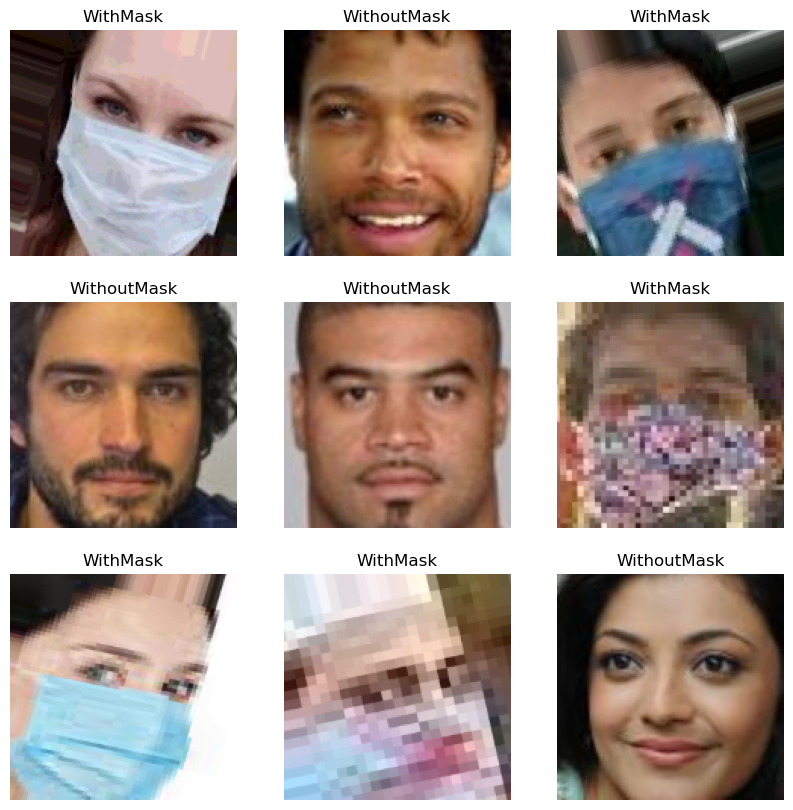

In [4]:
# show sample images
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

## 3. Augment Data
Perform image transformations (such as rotations, flips, and zooms) to the dataset to increase its size and make the model more robust.

In [90]:
# generator to augment train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    samplewise_center=True,
    samplewise_std_normalization=True,
    fill_mode='nearest'
)
# generator to rescale(only) val and test set
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [91]:
def prepare_dataset(img_size:tuple, train_batch_size:int = 32, val_batch_size:int=32, test_batch_size:int=1) -> Tuple[DirectoryIterator, DirectoryIterator, DirectoryIterator]:
    """
        resize images, rescale, augment, and create batches

    Args:
        img_size: (height, width) dimensions to resize images
        train_batch_size: training batches
        val_batch_size: validation batches
        test_batch_size: test batches       #  set to 1

    Returns: preprocessed train, val, test datasets

    """
    train_ds = train_datagen.flow_from_directory(
        directory=train_dir,
        target_size=img_size,
        batch_size=train_batch_size,
        shuffle=True,
        seed=69,
        class_mode='binary'
    )
    validation_ds = val_datagen.flow_from_directory(
        directory=validation_dir,
        target_size=img_size,
        batch_size=val_batch_size,
        shuffle=True,
        seed=69,
        class_mode='binary'
    )
    test_ds = test_datagen.flow_from_directory(
        directory=test_dir,
        target_size=img_size,
        batch_size=test_batch_size,
        shuffle=False,
        seed=69,
        class_mode='binary'
    )

    return train_ds, validation_ds, test_ds

In [92]:
def build_pretrained_model(pretrained_model):
    """apply transfer learning from a pretrained model and build a simple binary classification model"""
    for layer in pretrained_model.layers:
        layer.trainable=False

    model = Sequential()
    model.add(pretrained_model)

    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))

    return model


def compile_model(model):
    """compile model"""
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


def fit_model_and_get_history(model, train_dataset, validation_dataset, epochs=10, verbose=1):
    """fit model and get history"""

    callback = EarlyStopping(
        monitor= 'val_loss',
        min_delta=.00001,
        patience=3,
        verbose=1,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    )
    model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, verbose=verbose, callbacks=callback)

    return model

## 4. Predict with a Base Model
In this step, we train a simple CNN base model. This serves as a baseline to compare against more complex models in later stages.

In [93]:
IMG_SIZE = (224,224)
train_dataset, validation_dataset, test_dataset = prepare_dataset(IMG_SIZE)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [96]:
# create model
model = Sequential(layers=[
    Conv2D(32, kernel_size=3, activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=2, strides=2),
    Conv2D(64, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),
    Conv2D(128, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 26, 26, 128)     

In [97]:
%%time
# compile_model(model)
# base_history = fit_model_and_get_history(model, train_dataset, validation_dataset, epochs=40)
# base_accuracy = model.evaluate(test_dataset)
# model.save('models/base.h5')

model = load_model('models/base.h5')
base_accuracy = model.evaluate(test_dataset)

Epoch 1/40
313/313 [==============================] - 77s 242ms/step - loss: 0.2271 - accuracy: 0.9182 - val_loss: 0.2435 - val_accuracy: 0.9250
Epoch 2/40
313/313 [==============================] - 75s 239ms/step - loss: 0.1321 - accuracy: 0.9558 - val_loss: 0.3160 - val_accuracy: 0.8687
Epoch 3/40
313/313 [==============================] - 75s 239ms/step - loss: 0.1022 - accuracy: 0.9632 - val_loss: 0.4567 - val_accuracy: 0.7575
Epoch 4/40
313/313 [==============================] - 75s 239ms/step - loss: 0.0752 - accuracy: 0.9731 - val_loss: 0.3426 - val_accuracy: 0.8525
Epoch 4: early stopping
992/992 [==============================] - 4s 4ms/step - loss: 0.3700 - accuracy: 0.8538
CPU times: total: 7min 17s
Wall time: 5min 5s


## 5. Predict with Pretrained Models
In this stage, we utilize state-of-the-art CNN architectures pretrained with 'imagenet' dataset for face mask detection.

### 5.1. InceptionV3
<b>InceptionV3</b> is a deep CNN architecture known for its innovative 'inception' module, which employs multiple filter sizes within a single layer. This design allows the network to capture features at various scales and significantly improves the efficiency of the model by reducing the number of parameters.

In [99]:
IMG_SIZE = (256,256)
train_dataset, validation_dataset, test_dataset = prepare_dataset(IMG_SIZE)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [100]:
%%time
# inception_V3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(256,256,3))
# model = build_pretrained_model(inception_V3)
# compile_model(model)
# inception_history = fit_model_and_get_history(model, train_dataset, validation_dataset)
# inception_accuracy = model.evaluate(test_dataset)
# model.save('models/inceptionv3.h5')

model = load_model('models/inceptionv3.h5')
inception_accuracy = model.evaluate(test_dataset)

Epoch 1/10
313/313 [==============================] - 106s 328ms/step - loss: 0.1887 - accuracy: 0.9644 - val_loss: 5.7373e-04 - val_accuracy: 1.0000
Epoch 2/10
313/313 [==============================] - 100s 319ms/step - loss: 0.1990 - accuracy: 0.9745 - val_loss: 0.0014 - val_accuracy: 0.9987
Epoch 3/10
313/313 [==============================] - 100s 319ms/step - loss: 0.1981 - accuracy: 0.9770 - val_loss: 3.9254e-04 - val_accuracy: 1.0000
Epoch 4/10
313/313 [==============================] - 100s 320ms/step - loss: 0.1937 - accuracy: 0.9806 - val_loss: 0.0035 - val_accuracy: 0.9987
Epoch 5/10
313/313 [==============================] - 99s 315ms/step - loss: 0.1919 - accuracy: 0.9826 - val_loss: 0.0024 - val_accuracy: 0.9987
Epoch 6/10
313/313 [==============================] - 98s 314ms/step - loss: 0.2266 - accuracy: 0.9815 - val_loss: 1.2032e-07 - val_accuracy: 1.0000
Epoch 7/10
313/313 [==============================] - 98s 313ms/step - loss: 0.1572 - accuracy: 0.9848 - val_loss:

### 5.2. ResNet101V2
<b>ResNet101V2</b> is a variant of the ResNet architecture, characterized by its deep structure and utilization of skip connections or residual blocks. These skip connections allow the network to mitigate the vanishing gradient descent problem, enabling the training of very deep neural networks with improved performance.

In [101]:
IMG_SIZE = (256,256)
train_dataset, validation_dataset, test_dataset = prepare_dataset(IMG_SIZE)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [102]:
%%time
# resnet101v2 = ResNet101V2(weights='imagenet', include_top=False, input_shape=(256,256,3))
# model = build_pretrained_model(resnet101v2)
# compile_model(model)
# resnet_history = fit_model_and_get_history(model, train_dataset, validation_dataset)
# resnet_accuracy = model.evaluate(test_dataset)
# model.save("models/resnet101v2.h5")

model = load_model('models/resnet101v2.h5')
resnet_accuracy = model.evaluate(test_dataset)

Epoch 1/10
313/313 [==============================] - 145s 450ms/step - loss: 0.9786 - accuracy: 0.9571 - val_loss: 0.0047 - val_accuracy: 0.9987
Epoch 2/10
313/313 [==============================] - 139s 444ms/step - loss: 0.9717 - accuracy: 0.9726 - val_loss: 2.2581e-06 - val_accuracy: 1.0000
Epoch 3/10
313/313 [==============================] - 139s 444ms/step - loss: 0.8649 - accuracy: 0.9787 - val_loss: 2.4490e-04 - val_accuracy: 1.0000
Epoch 4/10
313/313 [==============================] - 139s 445ms/step - loss: 0.8567 - accuracy: 0.9785 - val_loss: 7.2097e-06 - val_accuracy: 1.0000
Epoch 5/10
313/313 [==============================] - 140s 446ms/step - loss: 0.6926 - accuracy: 0.9832 - val_loss: 7.4268e-11 - val_accuracy: 1.0000
Epoch 5: early stopping
992/992 [==============================] - 42s 42ms/step - loss: 0.1528 - accuracy: 0.9980


### 5.3. VGG19
<b>VGG19</b> stands for 'Visual Geometry Group 19', is characterized by its simple and uniform design, consisting of 19 layers, including convolutional and max-pooling layers, followed by fully connected layers for classification.

In [103]:
IMG_SIZE = (224,224)
train_dataset, validation_dataset, test_dataset = prepare_dataset(IMG_SIZE)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [104]:
%%time
# vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
# model = build_pretrained_model(vgg19)
# compile_model(model)
# vgg19_history = fit_model_and_get_history(model, train_dataset, validation_dataset)
# vgg19_accuracy = model.evaluate(test_dataset)
# model.save('models/vgg19.h5')

model = load_model('models/vgg19.h5')
vgg19_accuracy = model.evaluate(test_dataset)

Epoch 1/10
313/313 [==============================] - 108s 343ms/step - loss: 0.0651 - accuracy: 0.9755 - val_loss: 0.1944 - val_accuracy: 0.9225
Epoch 2/10
313/313 [==============================] - 104s 331ms/step - loss: 0.0252 - accuracy: 0.9922 - val_loss: 0.3523 - val_accuracy: 0.8600
Epoch 3/10
313/313 [==============================] - 103s 328ms/step - loss: 0.0224 - accuracy: 0.9928 - val_loss: 0.1685 - val_accuracy: 0.9350
Epoch 4/10
313/313 [==============================] - 102s 326ms/step - loss: 0.0161 - accuracy: 0.9948 - val_loss: 0.3170 - val_accuracy: 0.8850
Epoch 5/10
313/313 [==============================] - 102s 325ms/step - loss: 0.0160 - accuracy: 0.9947 - val_loss: 0.1832 - val_accuracy: 0.9200
Epoch 6/10
313/313 [==============================] - 103s 327ms/step - loss: 0.0186 - accuracy: 0.9936 - val_loss: 0.1919 - val_accuracy: 0.9262
Epoch 6: early stopping
992/992 [==============================] - 25s 25ms/step - loss: 0.1302 - accuracy: 0.9526


### 5.4. VGG16
<b>VGG16</b> is another variant of VGG family, with 16 layers, likewise known for its simplicity (consisting of  uniform architecture with a series of convolutional and max-pooling layers, followed by fully connected layers) and effectiveness in image classification tasks.

In [105]:
IMG_SIZE = (224,224)
train_dataset, validation_dataset, test_dataset = prepare_dataset(IMG_SIZE)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [106]:
%%time
# vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
# model = build_pretrained_model(vgg16)
# compile_model(model)
# vgg16_history = fit_model_and_get_history(model, train_dataset, validation_dataset)
# vgg16_accuracy = model.evaluate(test_dataset)
# model.save('models/vgg16.h5')

model = load_model('models/vgg16.h5')
vgg16_accuracy = model.evaluate(test_dataset)

Epoch 1/10
313/313 [==============================] - 86s 272ms/step - loss: 0.0537 - accuracy: 0.9797 - val_loss: 0.1138 - val_accuracy: 0.9688
Epoch 2/10
313/313 [==============================] - 85s 271ms/step - loss: 0.0173 - accuracy: 0.9947 - val_loss: 0.1239 - val_accuracy: 0.9488
Epoch 3/10
313/313 [==============================] - 88s 280ms/step - loss: 0.0152 - accuracy: 0.9947 - val_loss: 0.3480 - val_accuracy: 0.8550
Epoch 4/10
313/313 [==============================] - 86s 273ms/step - loss: 0.0135 - accuracy: 0.9947 - val_loss: 0.1564 - val_accuracy: 0.9388
Epoch 4: early stopping
992/992 [==============================] - 20s 20ms/step - loss: 0.1516 - accuracy: 0.9425


### 5.5. MobileNetV2
<b>MobileNetV2</b> is a lightweight and efficient deep learning architecure designed for mobile and embedded devices. It utilizes depthwise separable convolutions, which significantly reduces the number of parameters and computational complexity while maintaining high accuracy.

In [107]:
IMG_SIZE = (150,150)
train_dataset, validation_dataset, test_dataset = prepare_dataset(IMG_SIZE)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [108]:
# mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
# model = build_pretrained_model(mobilenet)
# compile_model(model)
# mobilenet_history = fit_model_and_get_history(model, train_dataset, validation_dataset)
# mobilenet_accuracy = model.evaluate(test_dataset)
# model.save('models/mobilenet.h5')

model = load_model('models/mobilenet.h5')
mobilenet_accuracy = model.evaluate(test_dataset)

Epoch 1/10
313/313 [==============================] - 43s 130ms/step - loss: 0.2242 - accuracy: 0.9642 - val_loss: 0.0682 - val_accuracy: 0.9837
Epoch 2/10
313/313 [==============================] - 40s 127ms/step - loss: 0.1064 - accuracy: 0.9832 - val_loss: 0.0666 - val_accuracy: 0.9825
Epoch 3/10
313/313 [==============================] - 40s 127ms/step - loss: 0.0825 - accuracy: 0.9871 - val_loss: 0.0800 - val_accuracy: 0.9787
Epoch 4/10
313/313 [==============================] - 40s 128ms/step - loss: 0.1048 - accuracy: 0.9866 - val_loss: 0.0786 - val_accuracy: 0.9900
Epoch 5/10
313/313 [==============================] - 40s 127ms/step - loss: 0.1090 - accuracy: 0.9867 - val_loss: 0.1397 - val_accuracy: 0.9787
Epoch 5: early stopping
992/992 [==============================] - 10s 10ms/step - loss: 0.1449 - accuracy: 0.9778


### 5.6. DenseNet201
<b>DenseNet201</b> is a CNN architecture known for its dense connectivity patterns. Unlike traditional architectures, DenseNet connects each layer to every other layer in a feed-forward fashion, promoting feature reuse and enhancing the flow of gradients during training. This design leads to efficient parameter usage and enables better information propagation throughout the network.

In [109]:
IMG_SIZE = (128, 128)
train_dataset, validation_dataset, test_dataset = prepare_dataset(IMG_SIZE)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [110]:
# densenet = DenseNet201(weights='imagenet', include_top=False, input_shape=(128,128,3))
# model = build_pretrained_model(densenet)
# compile_model(model)
# densenet_history = fit_model_and_get_history(model, train_dataset, validation_dataset)
# densenet_accuracy= model.evaluate(test_dataset)
# model.save('models/densenet.h5')

model = load_model('models/densenet.h5')
densenet_accuracy= model.evaluate(test_dataset)

Epoch 1/10
313/313 [==============================] - 55s 153ms/step - loss: 0.0441 - accuracy: 0.9885 - val_loss: 0.0463 - val_accuracy: 0.9850
Epoch 2/10
313/313 [==============================] - 45s 143ms/step - loss: 0.0268 - accuracy: 0.9940 - val_loss: 0.0512 - val_accuracy: 0.9925
Epoch 3/10
313/313 [==============================] - 46s 147ms/step - loss: 0.0473 - accuracy: 0.9940 - val_loss: 0.0152 - val_accuracy: 0.9962
Epoch 4/10
313/313 [==============================] - 44s 140ms/step - loss: 0.0231 - accuracy: 0.9965 - val_loss: 0.0565 - val_accuracy: 0.9925
Epoch 5/10
313/313 [==============================] - 44s 140ms/step - loss: 0.0262 - accuracy: 0.9966 - val_loss: 0.0276 - val_accuracy: 0.9937
Epoch 6/10
313/313 [==============================] - 44s 141ms/step - loss: 0.0345 - accuracy: 0.9956 - val_loss: 0.0205 - val_accuracy: 0.9975
Epoch 6: early stopping
992/992 [==============================] - 41s 42ms/step - loss: 0.0368 - accuracy: 0.9950


## 6. Comparison of Models
We now assess their respective accuracies to identify which model excels in accurately classifying faces as masked or unmasked.

In [114]:
# names = [
#     'BaseModel',
#      'InceptionV3',
#      'ResNet101V2',
#      'VGG19',
#      'VGG16',
#      'MobileNetV2',
#      'DenseNet201'
# ]
#
# data = {'Nets':names,
#         'Accuracy': [
#             base_accuracy[1],
#             inception_accuracy[1],
#             resnet_accuracy[1],
#             vgg19_accuracy[1],
#             vgg16_accuracy[1],
#             mobilenet_accuracy[1],
#             densenet_accuracy[1]
#         ]
#         }
#
# df = pd.DataFrame(data)
# df.to_csv('results/models_comparison.csv', index=False)

df = pd.read_csv('results/models_comparison.csv')
df.sort_values('Accuracy', ascending=False)

,Nets,Accuracy
2,ResNet101V2,0.997984
1,InceptionV3,0.995968
6,DenseNet201,0.994960
5,MobileNetV2,0.977823
3,VGG19,0.952621
4,VGG16,0.942540
0,BaseModel,0.853831


## 7. References
[Image classification](https://www.tensorflow.org/tutorials/images/classification)- provided a guide on how to work with an image dataset from a directory.
[FaceMask: 6 Transfer Learning](https://www.kaggle.com/code/mdsalmanshams/facemask-6-transfer-learning-0-9969-in-1-epoch#1.-InceptionV3)- provided a guide on how to load pretrained models and build a model from it.